In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

/scratch/project/open-32-14/pimenol1/miniconda3/envs/proteinttt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [16]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import esm
import biotite.structure.io as bsio
from collections import defaultdict

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures")
SABDAB_SUMMARY_PATH = base_path / Path("summary_with_seq_chothia.tsv")
OUTPUT_PATH = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("chothia")
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PATH}")

Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/summary_with_seq_chothia.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/chothia
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures


In [ ]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df = df.query("chain_type == 'antigen_chain'").drop_duplicates(subset=['pdb'])
df.head(5)

Entries in summary: 51,391


,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before
0,8ykd,A,antigen_chain,LSAEDKAAVERSKMIEKQLQKDKQVYRATHRLLLLGADNSGKSTIVKQMRIYHSGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFV...,"['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...","['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...",2.9,72.011163,0.80569,0.340307
1,8ykd,S,Hchain,VQLVESGGGLVQPGGSRKLSCSASGFAFSSFGMHWVRQAPEKGLEWVAYISSGSGTIYYADTVKGRFTISRDDPKNTLFLQMTSLRSEDTAMYYCV...,"['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '...","['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'...",2.9,83.441442,0.21743,0.279889
2,8ykd,s,Lchain,DIVMTQATSSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPGQSPQLLIYRMSNLASGVPDRFSGSGSGTAFTLTISRLEAEDVGVYYCMQH...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",2.9,89.154623,0.32104,0.363930
3,8ykd,A,antigen_chain,LSAEDKAAVERSKMIEKQLQKDKQVYRATHRLLLLGADNSGKSTIVKQMRIYHSGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFV...,"['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...","['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...",2.9,72.011163,0.80569,0.340307
4,8ykd,B,antigen_chain,LDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSW...,"['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...","['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...",2.9,84.189869,0.22064,0.272015


In [ ]:
# from proteinttt.utils.parsers import fetch_and_parse_sequences_ch_2
# df_sequence = fetch_and_parse_sequences_ch_2(df, PDB_FILES_PATH)
# df_sequence.to_csv(path_or_buf=base_path / "summary_with_seq_chothia.tsv", sep="\t", index=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

Using cuda


In [12]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PATH):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    out_path = out_dir / f"{pdb_id}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = struct.b_factor.mean()
    tm_score = calculate_tm_score(
        pred_path=out_path,
        pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    lddt = lddt_score(pdb_ref=PDB_FILES_PATH / f"{pdb_id}.pdb", pdb_model=out_path)
    
    return pLDDT, tm_score, lddt

In [ ]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PATH):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    model.ttt(sequence)
    pLDDT_after, tm_score_after, lddt = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after, tm_score_after, lddt

## Before

In [22]:
df.head(5)

,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before
0,8ykd,A,antigen_chain,LSAEDKAAVERSKMIEKQLQKDKQVYRATHRLLLLGADNSGKSTIVKQMRIYHSGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFV...,"['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...","['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...",2.9,72.011163,0.80569,0.340307
1,8ykd,S,Hchain,VQLVESGGGLVQPGGSRKLSCSASGFAFSSFGMHWVRQAPEKGLEWVAYISSGSGTIYYADTVKGRFTISRDDPKNTLFLQMTSLRSEDTAMYYCV...,"['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '...","['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'...",2.9,83.441442,0.21743,0.279889
2,8ykd,s,Lchain,DIVMTQATSSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPGQSPQLLIYRMSNLASGVPDRFSGSGSGTAFTLTISRLEAEDVGVYYCMQH...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",2.9,89.154623,0.32104,0.363930
3,8ykd,A,antigen_chain,LSAEDKAAVERSKMIEKQLQKDKQVYRATHRLLLLGADNSGKSTIVKQMRIYHSGIFETKFQVDKVNFHMFDVGAQRDERRKWIQCFNDVTAIIFV...,"['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...","['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',...",2.9,72.011163,0.80569,0.340307
4,8ykd,B,antigen_chain,LDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRTRRTLRGHLAKIYAMHWGTDSRLLVSASQDGKLIIWDSYTTNKVHAIPLRSSW...,"['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...","['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...",2.9,84.189869,0.22064,0.272015


In [7]:
num_of_low = 0
col = 'sequence'

In [ ]:
for i, row in df.iterrows():
    if pd.notna(row.get("pLDDT_before")) :
        continue
    if pd.isna(row[col]) or pd.notna(row['pLDDT_before']):
        continue
    
    pdb_id = str(row.get("pdb"))
    
    seq = str(row[col]).strip().upper()
    tag_chain = f'{row["chain"]}'

    try:
        pLDDT_before, tm_score_before, lddt_before = predict_structure(model, seq, pdb_id, tag=f'{tag_chain}_before_ttt', out_dir=OUTPUT_PATH)
        df.at[i, f'pLDDT_before'] = pLDDT_before
        df.at[i, f'tm_score_before'] = tm_score_before
        df.at[i, 'LDDT_before'] = lddt_before
        if pLDDT_before < 70:
            num_of_low+=1
            print(pLDDT_before)
            df.to_csv(base_path / Path("summary_antigen.tsv"), sep="\t", index=False)
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag_chain}: {e}")
            
df.to_csv(base_path / Path("summary_antigen.tsv"), sep="\t", index=False)

A
S
s
A
B
G
N
A
H
L
D
I
M
G
P
S
T
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
A
H
L
D
I
M
G
N
O
P
S
T
D
H
L
E
I
M
F
J
N
K
O
P
A
B
N
G
I
T
S
s
G
I
T
S
s
I
T
S
s
C
D
A
B
A
H
L
C
I
M
E
J
N
A
H
L
C
I
M
E
J
N
E
J
N
A
H
L
C
I
M
A
H
L
C
I
M
E
J
N
A
H
L
C
I
M
E
J
N
A
D
C
E
B
F
A
D
B
E
C
F
H
L
B
A
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
B
E
I
C
F
J
D
G
K
B
E
I
C
F
J
D
G
K
A
H
L
B
E
I
C
F
J
D
G
K
A
H
L
D
H
L
E
I
M
F
J
N
K
O
P
A
H
L
A
G
S
s
A
B
N
A
S
s
A
B
N
A
S
s
A
B
N
A
D
Q
a
B
C
F
c
O
E
e
F
G
g
I
J
M
i
L
K
k
A
B
E
e
A
H
L
Z
D
X
A
Y
B
V
C
A
B
C
A
B
G
S
s
A
B
S
s
A
B
H
L
C
D
I
M
E
F
J
N
B
E
D
F
A
H
L
B
I
M
C
J
N
A
H
L
S
H
L
A
C
B
D
B
A
B
A
A
B
C
D
A
B
C
D
A
B
S
s
F
P
H
L
A
B
N
A
C
B
D
F
C
E
D
B
A
A
G
J
B
H
K
C
I
L
C
H
L
B
I
M
A
J
N
H
L
H
L
A
H
L
A
B
H
L
D
B
D
A
H
L
B
C
A
D
A
C
B
D
A
H
L
B
C
D
A
H
L
A
H
L
B
C
D
A
H
L
B
E
F
A
H
L
B
C
D
A
H
L
B
C
D
B
C
D
A
H
L
B
H
L
A
E
F
A
H
L
N
B
A
S
s
B
A
S
s
B
A
S
s
B
G
A
S
s
B
E
D
G
J
I
L
O
N
A
H
L
B
E
D
G
J
I
L


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykdA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykdS: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykds: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykdB: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykdG: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8ykdN: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9ejeA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

B
B
E
C
A
G
H
A
B
H
L
A
B
F
G
C
D
F
G
A
E
D
B
F
G
C
E
D
F
G
E
F
G
B
D
E
B
D
E
B
D
E
B
C
B
D
B
C
A
B
S
s
R
H
L
K
A
B
N
B
C
G
N
B
I
F
A
H
D
C
G
E
B
G
F
A
H
E
C
I
D
A
B
b
A
C
c
E
B
A
F
A
G
C
B
D
H
E
I
K
J
L
B
C
E
e
B
C
E
e
B
C
E
e
A
B
C
D
F
H
L
A
C
D
F
H
L
A
H
L
A
B
C
A
B
E
e
B
C
S
s
B
C
S
s
A
B
S
s
A
B
N
A
B
S
s
A
B
S
s
F
A
B
F
H
L
F
D
C
B
A
D
C
B
j
i
C
h
g
A
n
l
B
j
i
H
L
H
L
A
H
L
A
G
F
C
H
I
A
H
D
B
E
C
D
A
C
B
A
H
L
A
B
N
A
B
N
A
B
N
A
C
B
D
A
E
B
F
G
I
H
J
G
K
H
L
C
D
G
I
A
B
H
J
E
F
K
L
H
L
H
L
D
H
L
C
A
B
C
H
L
D
B
A
H
L
H
L
C
H
L
D
H
L
H
L
A
B
C
H
L
D
A
B
D
H
L
C
A
B
M
H
L
E
A
B
E
G
I
A
H
L
C
J
K
A
H
L
C
G
I
E
J
K
A
H
L
C
G
I
E
J
K
A
H
L
C
J
K
E
G
I
A
M
N
B
D
F
C
E
G
B
A
N
B
A
N
B
A
N
A
B
N
n
D
H
L
A
B
H
L
A
B
H
L
A
F
B
C
A
C
B
E
D
F
G
I
H
K
J
L
B
A
D
C
A
B
A
B
A
C
A
B
A
B
A
B
A
B
E
e
E
A
B
E
H
L
E
D
F
B
H
L
B
H
L
C
H
L
D
A
B
D
E
F
A
B
C
D
E
F
A
B
C
A
H
L
A
B
C
C
A
a
C
D
d
B
F
f
B
A
a
A
H
L
B
C
B
C
A
C
B
D
E
H
L
E
H
L
E
H
L
A
H
L
A
H
L
B
I
M
T
H
L
A
B
C
A
H
L
A
E
F
B
G
H
A
B
A
H


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9jg0L: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9jg0K: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9lybA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9lybB: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9lybN: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9lycB: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 9lycC: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
B
Q
R
B
S
T
A
D
F
A
E
G
C
H
J
C
I
K
A
D
F
B
E
H
C
G
K
A
H
L
B
D
F
C
E
G
C
H
L
A
H
L
B
D
E
e
A
B
h
l
B
H
L
A
H
L
N
H
B
I
A
C
D
G
E
J
B
D
G
C
E
H
A
F
I
V
A
H
L
B
H
L
A
I
M
C
J
N
A
H
L
A
B
C
A
B
C
D
A
J
D
E
B
K
H
L
C
I
F
G
A
B
D
d
B
D
C
A
F
E
B
D
C
A
F
E
B
D
C
A
F
E
B
D
C
A
F
E
A
a
R
r
G
R
r
C
A
a
B
C
A
D
H
L
A
B
H
L
I
A
B
G
H
L
I
A
B
G
H
L
C
H
L
A
B
S
s
B
A
S
s
B
A
S
s
B
A
S
s
B
A
S
s
H
L
A
H
L
A
H
L
A
B
C
D
H
L
A
D
C
B
F
E
A
D
C
B
F
E
A
a
B
b
C
c
A
C
B
H
A
H
B
C
A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
Y
T
U
V
W
X
A
B
C
D
B
C
H
L
A
D
E
F
C
D
H
L
A
B
E
F
A
C
D
B
E
F
A
H
L
B
C
D
M
N
O
G
H
I
A
B
C
P
Q
R
D
E
F
J
K
L
R
H
L
R
A
B
X
Y
N
Y
X
N
X
Y
Z
N
X
Y
Z
N
B
A
H
L
H
L
H
L
A
H
G
C
F
E
B
J
I
D
K
L
C
F
E
A
H
G
B
J
I
D
K
L
C
F
E
A
H
G
B
J
I
D
K
L
C
F
E
A
H
G
B
J
I
D
K
L
A
H
L
B
A
N
B
E
D
d
B
E
D
d
C
B
S
s
B
H
L
I
K
A
B
A
A
B
C
R
H
L
R
I
M
D
C
H
L
P
H
L
P
H
L
A
C
D
E
C
D
I
A
B
F
J
B
D
E
C
A
F
A
H
L
H
L
M
N
C
A
B
F
D
E
F
D
C
E
B
A
H
L
R
A
B
R
C
D
R


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8qcmC: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8qcmA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8qcmF: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8qcmE: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8r3wA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8r3wa: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8r3wR: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

s
E
F
L
K
A
B
A
C
E
F
H
L
C
D
G
I
A
B
J
K
A
B
V
X
G
I
S
T
H
J
U
W
A
B
H
L
C
D
E
F
G
I
J
K
A
B
H
L
C
D
E
F
G
I
J
K
E
F
G
H
K
k
B
C
D
N
n
H
L
h
l
H
L
A
B
D
E
A
B
D
C
F
E
J
I
H
G
C
H
L
D
A
B
A
C
B
D
A
D
E
A
B
C
C
A
B
F
D
E
A
D
E
C
A
B
A
B
C
D
E
F
G
H
A
B
C
H
L
B
M
N
C
A
A
B
C
D
A
B
B
U
E
V
A
B
C
D
A
B
C
D
E
A
B
H
L
A
B
H
L
A
B
H
L
B
J
I
D
K
L
B
J
I
D
K
L
A
G
B
H
B
H
A
G
A
B
C
F
f
B
G
g
C
E
e
B
F
f
A
H
h
A
L
B
M
E
O
F
P
G
Q
H
R
I
S
I
T
K
U
C
D
N
A
B
D
F
A
D
E
B
C
B
C
D
E
C
A
B
H
L
A
C
B
D
A
B
A
H
L
E
H
L
A
D
E
B
H
L
C
F
G
A
H
L
B
D
E
C
F
G
A
D
E
B
H
L
C
F
G
B
H
L
C
D
E
A
F
G
B
L
C
M
D
N
E
O
F
P
G
Q
H
R
I
S
J
T
K
U
A
V
A
L
B
M
A
U
B
V
C
W
D
X
E
Y
F
Z
G
a
H
b
I
c
J
d
K
e
L
f
M
g
N
h
O
i
P
j
Q
k
R
l
S
m
T
n
C
A
B
D
H
L
P
H
L
E
A
B
F
C
D
A
H
L
C
I
M
E
J
N
A
H
L
A
C
B
A
C
B
D
F
E
A
C
B
D
A
H
L
A
Y
B
W
C
U
D
F
E
A
C
B
F
E
C
B
A
B
H
h
A
B
N
A
B
E
e
A
D
E
B
F
G
E
H
L
A
C
C
B
D
A
B
G
N
A
B
N
B
E
F
A
D
G
H
D
G
K
C
A
I
J
A
H
L
B
I
M
C
J
N
A
H
L
B
I
M
C
J
N
A
B
S
s
A
B
S
s
A
D
E
F
D
H
G
B
E
F
D
E
F
A


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8jr3D: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8jr3E: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8jr3B: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8jr3C: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8kg5B: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8kg5C: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8kg5D: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

H
h
A
B
H
h
A
B
H
h
B
C
E
A
D
E
H
A
B
C
D
E
F
A
C
B
D
F
E
H
L
B
A
C
H
L
D
B
A
A
B
N
A
B
N
A
B
N
A
B
N
A
B
N
C
A
B
E
H
L
A
B
C
S
s
A
M
N
A
H
L
A
M
N
A
H
L
D
A
B
C
D
B
D
A
A
C
B
D
A
D
B
C
B
A
C
D
E
F
D
C
E
e
J
C
D
E
A
B
H
F
G
L
I
K
I
A
B
J
C
D
M
E
F
P
G
H
A
B
C
D
E
F
A
B
C
D
A
B
A
B
E
e
F
A
E
C
H
L
A
B
A
V
H
L
B
X
H
L
A
B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
A
B
E
e
A
A
A
D
E
H
L
E
A
B
E
C
B
E
F
A
H
L
C
J
K
G
E
F
A
H
L
B
I
M
C
J
N
A
H
L
A
I
M
A
J
N
A
E
B
H
D
I
B
G
D
F
A
K
D
N
A
O
B
M
A
E
B
H
D
I
B
G
D
F
A
K
A
J
D
F
B
G
B
H
D
I
A
E
D
N
A
O
B
M
A
E
B
C
D
F
A
E
B
C
A
E
D
G
B
F
A
C
D
F
E
B
A
E
D
C
A
B
N
B
A
C
G
F
A
B
I
H
D
E
K
J
C
G
F
A
B
I
H
D
E
K
J
B
C
G
F
D
E
K
J
B
C
G
F
D
E
K
J
C
G
F
A
B
I
H
D
E
K
J
C
G
F
A
B
I
H
D
E
K
J
R
H
L
R
E
F
Y
G
I
X
J
K
X
A
B
Y
C
D
E
H
L
E
A
B
E
A
B
E
H
L
A
C
M
H
L
F
H
L
A
B
C
D
B
C
E
e
B
C
E
e
A
a
B
b
C
D
N
n
C
D
N
n
D
C
E
e
D
C
E
e
A
B
N
A
B
C
S
s
A
B
S
s
A
B
S
s
A
H
L
K
H
L
H
L
A
C
D
E
G
H
I
K
L
A
C
D
E
G
H
I
K
L
H
L
D
A
E
B
F
C
H
L
C
B
A
A
B
C
D
H
L
A
B
N
B
A
D
C
F
E


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78J: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78D: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78F: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78B: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78G: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78H: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8g78I: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

E
B
C
E
A
H
L
A
H
L
A
C
B
D
B
C
A
D
B
C
A
D
C
H
L
C
H
L
C
H
L
C
E
F
A
H
L
G
J
K
A
H
L
B
C
D
E
F
G
A
D
F
B
E
G
C
H
L
B
D
F
C
E
G
A
H
L
A
K
C
X
Y
A
H
L
B
M
N
B
X
Y
A
H
L
C
M
N
H
L
A
A
B
A
A
E
H
L
E
H
L
A
C
B
D
E
G
F
H
Q
A
B
P
H
L
A
B
A
B
C
D
E
F
G
H
A
B
C
A
D
E
A
H
L
A
H
L
B
D
S
s
E
H
L
D
E
S
s
B
C
H
L
R
B
F
f
A
B
G
H
C
D
I
J
E
F
K
L
A
B
G
H
C
D
I
J
E
F
K
L
A
B
G
H
C
D
I
J
E
F
K
L
A
B
C
D
E
F
G
H
H
L
A
B
H
L
C
D
B
A
B
C
B
A
B
C
A
H
L
B
C
A
E
F
A
H
L
A
H
L
A
C
D
B
E
F
A
C
D
B
E
F
A
B
C
D
A
C
D
B
E
F
A
C
D
B
E
F
A
B
H
L
H
L
H
L
B
A
H
L
B
A
H
L
A
H
L
A
H
L
C
J
K
A
H
L
C
J
K
A
H
L
C
J
K
A
H
L
C
J
K
A
H
L
C
J
K
A
B
N
A
B
N
A
E
C
B
F
D
A
E
C
B
F
D
A
E
C
B
F
D
A
E
C
B
F
D
A
E
C
B
F
D
A
E
C
B
F
D
A
E
C
B
F
D
E
B
A
E
D
C
T
A
B
T
H
L
U
C
D
U
I
M
F
H
B
A
E
G
D
C
A
D
A
D
C
E
B
C
L
A
E
J
D
F
K
A
G
B
H
D
I
A
C
B
D
E
G
F
H
I
K
J
L
A
C
D
B
E
F
G
H
I
B
A
H
h
A
B
S
s
A
B
N
A
B
N
a
D
E
b
F
G
c
H
I
A
C
B
A
B
C
D
H
K
I
J
E
F
M
N
G
L
O
P
S
T
V
W
Q
R
Y
U
A
B
C
D
M
m
E
G
H
N
n
F
G
H
M
m
B
C
D
N
n
C
D
H
L
B
E
F


/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7vE: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7vC: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7vB: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7vF: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7vD: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7wA: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag_chain}: {e}")
/tmp/ipykernel_576755/2901624986.py:23: UserWarning: 8j7wE: name 'predict_structure' is not defined
  warnings.warn(f"{pdb_id}{tag

KeyboardInterrupt: 

In [ ]:
raise SystemExit

## After

In [ ]:
c =0 
for i, row in df.iterrows():
    if len(str(row[col]).strip().upper()) > 500:
        continue
    c+=1
    pdb_id = str(row.get("pdb"))

    if pd.isna(row[col]):
        continue
    
    tag = row.get("chain_type", "unknown")
    seq = str(row[col]).strip().upper()
    tag_chain = f'{tag}_{row["chain"]}'

    try:
        pLDDT_after, tm_score_after = fold_chain(seq, pdb_id, model=model, tag=tag)
        df.at[i, 'pLDDT_after'] = pLDDT_after
        df.at[i, 'tm_score_after'] = tm_score_after
    except Exception as e:
        warnings.warn(f"{pdb_id}{tag}: {e}")
    if c % 50 == 0:
        df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

df.to_csv(base_path / "sabdab_summary_after_80_with_seq.tsv", sep="\t", index=False)

## Plots

KeyError: 'pLDDT_after'

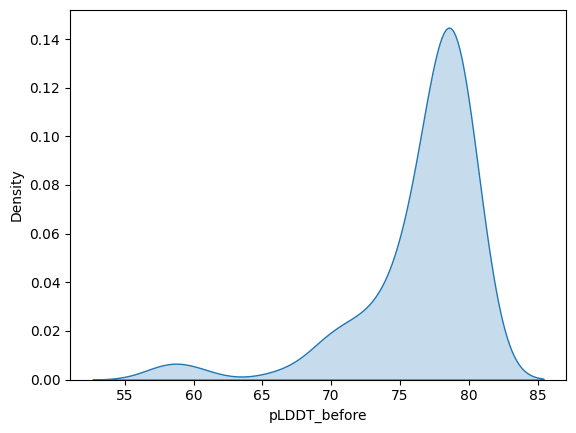

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.kdeplot(df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

In [18]:
sns.kdeplot(df['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(df['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

NameError: name 'sns' is not defined

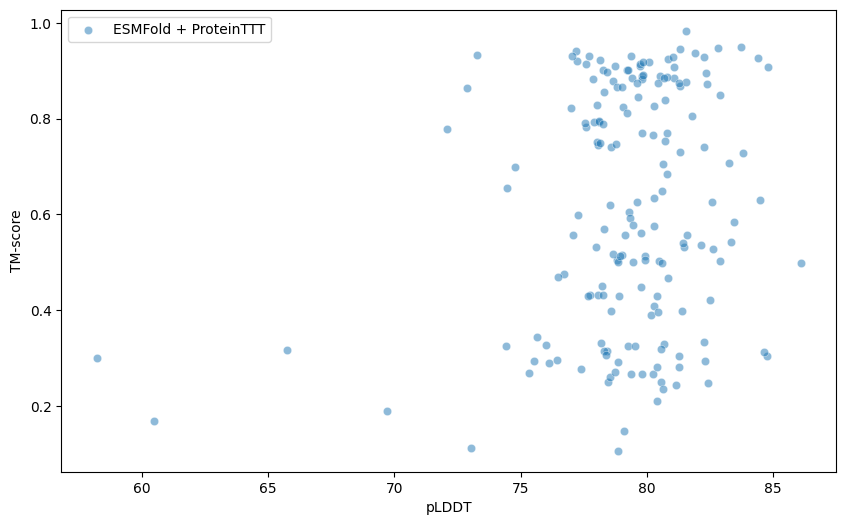

In [34]:
plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Hchain_pLDDT_before', y='Hchain_tm_score_before', data=df, label='ESMFold', alpha=0.5)
sns.scatterplot(x='Hchain_pLDDT_after', y='Hchain_tm_score_after', data=df, label='ESMFold + ProteinTTT', alpha=0.5)
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

In [ ]:
rows = df.dropna(subset=['Hchain_pLDDT_before', 'Hchain_tm_score_before'])
from scipy.stats import pearsonr
pearsonr(rows['Hchain_pLDDT_after'], rows['Hchain_tm_score_after'])

Text(0, 0.5, 'TM-score difference after and before ProteinTTT')

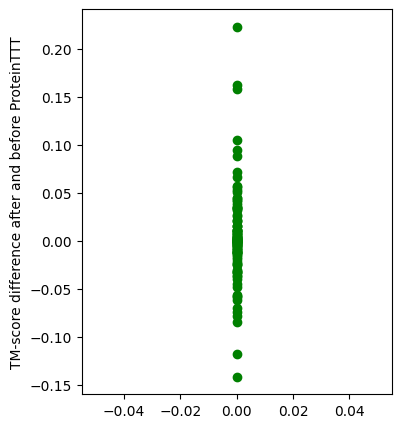

In [ ]:
df['Hchain_tm_score_diff'] = df['Hchain_tm_score_after'] - df['Hchain_tm_score_before']
plt.figure(figsize=(4, 5))
plt.scatter(np.zeros_like(df['Hchain_tm_score_diff']), df['Hchain_tm_score_diff'], color='green')
plt.ylabel('TM-score difference after and before ProteinTTT')

In [6]:
df_70 = pd.read_csv(base_path / "sabdab_summary_70.tsv", sep="\t", low_memory=False)

In [ ]:
df_70['diff'] = df_70['Hchain_tm_score_after'] - df_70['Hchain_tm_score_before']
top_10_diff = df_70.nlargest(10, 'diff')
print(top_10_diff[['pdb', 'Hchain', 'diff']])

      pdb Hchain     diff
62   7rug      L  0.22342
48   8k2w      N  0.16257
13   6hkg      C  0.15824
100  7kzb      A  0.10518
7    6y1r      B  0.09506
90   7nvo      N  0.08866
101  7d3m      H  0.07163
75   8ddk      A  0.06646
83   5cus      K  0.05765
69   8d0a      H  0.05618


## CDR pLDDT

In [ ]:
def extract_cdr_plddt_from_pdb(pdb_file_path, is_heavy: bool = True):
    """
    Extract pLDDT scores for CDR regions from a PDB file.
    Returns:
        Dict[str, Dict[str, float]]: Nested dictionary with structure:
        {
            'pair_1': {'H1': 85.2, 'H2': 90.1, 'H3': 78.5, 'L1': 88.3, 'L2': 92.1, 'L3': 82.7, 'CDR_mean': 86.2},
            'pair_2': {...},
            'overall': {'CDR_mean': 84.5}
        }
    """
    # CDR ranges based on Chothia numbering
    if is_heavy:
        CDR_RANGES = {
            'H1': (26, 32),
            'H2': (52, 56),
            'H3': (95, 102),
        }
    else: 
        CDR_RANGES = {
            'L1': (24, 34),
            'L2': (50, 56),
            'L3': (89, 97)
        }
        
        
    def is_in_cdr_region(residue_number: int):
        """Check if residue is in CDR region and return CDR name."""
        for cdr_name, (start, end) in CDR_RANGES.items():
            if start <= residue_number <= end:
                return cdr_name
        return None

    def extract_plddt_from_atoms(pdb_file_path):
        """Extract pLDDT values from B-factor column of ATOM records."""
        plddt_map = defaultdict(dict)

        with open(pdb_file_path, 'r') as f:
            for line in f:
                if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                    chain_id = line[21].strip()
                    residue_num_str = line[22:26].strip()
                    b_factor = float(line[60:66].strip())

                    try:
                        if residue_num_str[-1].isalpha():
                            residue_num = int(residue_num_str[:-1])
                        else:
                            residue_num = int(residue_num_str)
                    except ValueError:
                        print(f"Skipping line due to ValueError: {line.strip()}")
                        continue

                    plddt_map[chain_id][residue_num] = b_factor

        return plddt_map

    plddt_map = extract_plddt_from_atoms(pdb_file_path)
    print(f"pLDDT scores {plddt_map}")

    results = {}
    all_cdr_scores = []
    

    cdr_scores = {cdr: [] for cdr in ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']}

    for residue_num, plddt_score in plddt_map['A'].items():
        cdr_region = is_in_cdr_region( residue_num)
        if cdr_region:
            cdr_scores[cdr_region].append(plddt_score)

    # Calculate mean pLDDT for each CDR
    pair_results = {}
    for cdr_name, scores in cdr_scores.items():
        if scores:
            mean_score = sum(scores) / len(scores)
            pair_results[cdr_name] = round(mean_score, 2)
            all_cdr_scores.extend(scores)
        else:
            pair_results[cdr_name] = None  # CDR not found or no pLDDT data

    # Calculate mean for this chain
    valid_scores = [score for score in pair_results.values() if score is not None]
    if valid_scores:
        pair_results['CDR_mean'] = round(sum(valid_scores) / len(valid_scores), 2)
    else:
        pair_results['CDR_mean'] = None

    results = pair_results

    return results

In [9]:
df_1 = df.head(1)

In [34]:
for i, row in df_1.iterrows():
    
    pdb_file_H = f"/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures/{row.pdb}_{row.Hchain}_before_ttt.pdb"
    pdb_file_L = f"/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/all_structures/predicted_structures/{row.pdb}_{row.Lchain}_before_ttt.pdb"
    
    cdr_plddt = extract_cdr_plddt_from_pdb(pdb_file_H, is_heavy=True)

    print("CDR pLDDT Scores:")
    print("=" * 50)
    print(cdr_plddt)

pLDDT scores defaultdict(<class 'dict'>, {'A': {1: 81.6, 2: 84.79, 3: 90.87, 4: 92.27, 5: 94.2, 6: 94.91, 7: 93.0, 8: 91.07, 9: 91.4, 10: 91.79, 11: 93.72, 12: 92.83, 13: 92.36, 14: 91.77, 15: 90.86, 16: 92.39, 17: 93.65, 18: 94.8, 19: 95.37, 20: 95.36, 21: 95.08, 22: 94.39, 23: 93.75, 24: 91.47, 25: 89.03, 26: 80.48, 27: 75.65, 28: 80.16, 29: 80.08, 30: 76.78, 31: 76.14, 32: 79.95, 33: 81.44, 34: 85.55, 35: 85.91, 36: 89.74, 37: 88.71, 38: 90.65, 39: 91.35, 40: 89.72, 41: 89.27, 42: 87.31, 43: 85.84, 44: 82.5, 45: 84.97, 46: 85.48, 47: 85.67, 48: 87.36, 49: 85.59, 50: 84.7, 51: 84.24, 52: 80.18, 53: 79.11, 54: 75.27, 55: 76.57, 56: 74.47, 57: 77.68, 58: 81.45, 59: 80.12, 60: 83.32, 61: 82.65, 62: 82.24, 63: 82.81, 64: 85.4, 65: 85.22, 66: 87.69, 67: 91.18, 68: 91.5, 69: 92.79, 70: 91.16, 71: 91.79, 72: 90.2, 73: 90.36, 74: 87.03, 75: 88.6, 76: 90.43, 77: 91.42, 78: 92.77, 79: 92.61, 80: 94.35, 81: 94.34, 82: 95.13, 83: 94.07, 84: 92.72, 85: 91.45, 86: 92.7, 87: 91.19, 88: 90.48, 89: 9